In [1]:
using Distributions 
using IntervalSets
using ValueShapes
using ArraysOfArrays
using StatsBase 
using LinearAlgebra
using Random123
using HCubature
using HDF5

using BAT
using LaTeXStrings

In [2]:
# using Plots

In [3]:
using PyPlot

plt = PyPlot

SMALL_SIZE = 9
MEDIUM_SIZE = 9
BIGGER_SIZE = 10

plt.rc("font", size=SMALL_SIZE)          # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)    # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
# plt.rc("text", usetex=true)


function plot_tree(tree, axes::Array{Int64,1}, plot_ax; kwargs...)
    if tree.terminated_leaf == true
        r = matplotlib.patches.Rectangle([tree.bounds[axes[1],1],tree.bounds[axes[2],1]], tree.bounds[axes[1],2]-tree.bounds[axes[1],1], tree.bounds[axes[2],2]-tree.bounds[axes[2],1], fill=false, linewidth=0.8, color="black", alpha=1,; kwargs...,) #alpha=0.0, facecolor=color[i], edgecolor='k', linewidth=2.0)
        plot_ax.add_patch(r)
    else
        plot_tree(tree.left_child, axes, plot_ax; kwargs...)
        plot_tree(tree.right_child, axes, plot_ax; kwargs...)
    end
end


plot_tree (generic function with 1 method)

In [4]:
# Report Example:

sigma_1 = [0.32716446841097613 0.17276467616026275; 0.17276467616026275 0.33056237691918017]
sigma_3 = [0.01942201849281335 -0.003187584896683795; -0.003187584896683795 0.017175237584791444]

N = 2 
min_v = -20.
max_v = 20.
lgV = N*log(max_v-min_v); 

f(x;μ=[0, 0], sigma=sigma_1) = pdf(MvNormal(μ, sigma), x)

g(x) = (1/2.08)*(f(x, μ=[3.5, 3.5], sigma=sigma_1) + f(x, μ=[-3.5, -3.5], sigma=sigma_1) + 0.04*f(x, μ=[3.5, -3.5], sigma=sigma_3) + 0.04*f(x, μ=[-3.5, 3.5], sigma=sigma_3))

g (generic function with 1 method)

In [5]:
likelihood = params -> LogDVal((log(g(params.a))))
prior = NamedTupleDist(a = [[min_v .. max_v for i in 1:N]...],);
posterior = PosteriorDensity(likelihood, prior);

# Sampling

In [49]:
sampler = MetropolisHastings() # AHMC()

burnin_1 = MCMCBurninStrategy(
        max_nsamples_per_cycle = 400,
        max_nsteps_per_cycle = 400,
        max_time_per_cycle = 25,
        max_ncycles = 20
    )

max_nsteps = 10^10 
max_time = Inf

sampling_kwargs = (burnin = burnin_1, max_nsteps=max_nsteps, max_time=max_time);

The same with exploration sampler

In [50]:
# Sobol Sampler: 
# exploration_sampler = BAT.SobolSampler()
# exploration_kwargs = NamedTuple()
# n_exploration = (10^2, 40);

# MetropolisHastings: 
exploration_sampler = MetropolisHastings()

burnin_2 = MCMCBurninStrategy(
        max_nsamples_per_cycle = 2,
        max_nsteps_per_cycle = 2,
        max_time_per_cycle = 25,
        max_ncycles = 1
    )

tuning_2 = AdaptiveMetropolisTuning(
    λ = 0.5,
    α = 0.05..0.6,
    β = 1.5,
    c = 1e-4..1e2,
    r = 0.5
)

init_2 = MCMCInitStrategy(
    init_tries_per_chain = 8..30,
    max_nsamples_init = 25,
    max_nsteps_init = 250,
    max_time_init = 5
)

exploration_kwargs = (burnin = burnin_2, tuning=tuning_2, init=init_2)
n_exploration = (50, 10);

Space partitioning can be done using `BAT.KDTreePartitioning` algorithm

In [51]:
partitioner = BAT.KDTreePartitioning(
        partition_dims = [1,2,], # dimension indices that are considered for partition
        extend_bounds=true # "false" is appropriate for debugging, very fast tuning /convergence 
    );

To integrate subspaces, any `BAT.IntegrationAlgorithm` can be used: 

In [52]:
integrator = AHMIntegration(  
        whitening= CholeskyPartialWhitening(),
        autocorlen= GeyerAutocorLen(),
        volumetype = :HyperRectangle,
        max_startingIDs = 10000,
        max_startingIDs_fraction = 2.5,
        rect_increase = 0.1,
        warning_minstartingids = 16,
        dotrimming = true,
        uncertainty= [:cov]
    );

Finally, `PartitionedSampling` can be defined using settings: 

In [53]:
algorithm = PartitionedSampling(
        sampler = sampler,
        exploration_sampler = exploration_sampler,
        partitioner = partitioner,
        integrator = integrator,
        exploration_kwargs = exploration_kwargs,
        sampling_kwargs = sampling_kwargs,
        n_exploration = n_exploration
    );

In [54]:
n_chains = 10
n_samples = 10^3 
n_subspaces = 20;

output_sp_ms = bat_sample(posterior, (n_samples, n_chains, n_subspaces), algorithm);

samples_3 = output_sp_ms.result;

┌ Info: Generating Exploration Samples
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/partitioned_sampling/partition_sample.jl:77
┌ Info: Initializing new RNG of type Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Warning: MCMC tuning of 10 chains aborted after 1 cycle(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:108
┌ Info: Constructing Part

In [55]:
flat_samples = flatview(unshaped.(samples_3.v))
exp_x = flatview(unshaped.(output_sp_ms.exp_samples.v))[1,:]
exp_y = flatview(unshaped.(output_sp_ms.exp_samples.v))[2,:]

histogram_2D_wr = fit(Histogram, (flat_samples[1,:],flat_samples[2,:]), weights(samples_3.weight), nbins=200)
histogram_2D_wr = normalize(histogram_2D_wr, mode=:pdf);

In [56]:
weights_wo = Float64[]

for (enum, ind) in enumerate(output_sp_ms.info.samples_ind)
    subs_ind = enum
    smpl_ind = output_sp_ms.info.samples_ind[subs_ind]
    smpl_tot_weight = output_sp_ms.info.sum_weights[subs_ind]
    smpl_trunc = samples_3[smpl_ind]
    smpl_int = output_sp_ms.info.density_integral[subs_ind].val
#     tmp = round.(Integer, smpl_tot_weight .* smpl_trunc.weight ./ smpl_int)
    tmp =  smpl_tot_weight .* smpl_trunc.weight ./ smpl_int
    append!(weights_wo, tmp)
end

@show unique(weights_wo)[1:5]

histogram_2D_wo = fit(Histogram, (flat_samples[1,:],flat_samples[2,:]), weights(weights_wo), nbins=200)
histogram_2D_wo = normalize(histogram_2D_wo, mode=:pdf);

(unique(weights_wo))[1:5] = [6.0, 4.0, 1.0, 2.0, 3.0]


In [67]:
exp_color = "k" #PyPlot.cm.RdYlBu_r(0,0,)

"k"

In [71]:
levels_quantiles = [0.4, 0.7, 0.8, 0.9, 0.99, 1,]
# colors = vcat([1 1 1 1], plt.cm.Blues(range(0, stop=1, length=length(levels_quantiles)))[2:end,:]);
colors = plt.cm.Blues(range(0, stop=1, length=length(levels_quantiles)))

6×4 Array{Float64,2}:
 0.968627   0.984314  1.0       1.0
 0.814118   0.883922  0.949804  1.0
 0.579608   0.770196  0.873725  1.0
 0.29098    0.59451   0.78902   1.0
 0.0901961  0.392941  0.670588  1.0
 0.0313725  0.188235  0.419608  1.0

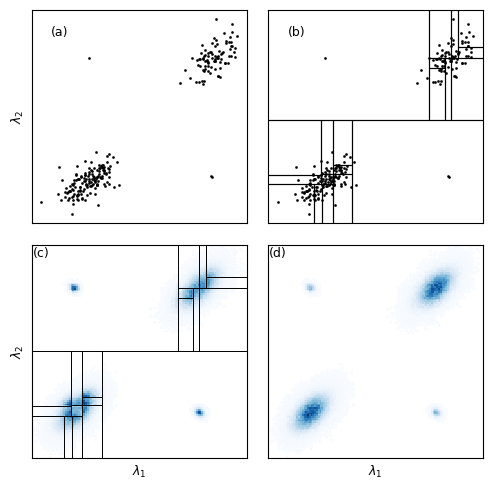

PyObject Text(26.099999999999994, 0.5, '$\\lambda_2$')

In [76]:
fig, ax = plt.subplots(2,2, figsize=(5.826767123287671, 5.826767123287671))
fig.subplots_adjust(wspace=0.1, hspace=0.1)

ax[1,1].scatter(exp_x, exp_y, color=exp_color, s=1, alpha=0.9) #midnightblue
ax[1,1].text(-5.0,5.0,"(a)",horizontalalignment="center", verticalalignment="center")


ax[1,2].scatter(exp_x, exp_y, color=exp_color, s=1, alpha=0.9) #color=get_cmap("tab10", 1) | ColorMap("tab10").colors[1]
ax[1,2].text(-5,5,"(b)",horizontalalignment="center", verticalalignment="center")

plot_tree(output_sp_ms.part_tree, [1,2], ax[1,2], color="black", linewidth=0.8)

ax[2, 1].pcolormesh(midpoints(histogram_2D_wo.edges[1]), midpoints(histogram_2D_wo.edges[2]), replace(histogram_2D_wo.weights', 0=>NaN), cmap=ColorMap(colors) , rasterized=true) 

plot_tree(output_sp_ms.part_tree, [1,2], ax[2, 1], linewidth=0.6, color="black", alpha=1)

ax[2,1].text(-5.3,5.5,"(c)",horizontalalignment="center", verticalalignment="center")

ax[2,2].pcolormesh(midpoints(histogram_2D_wr.edges[1]), midpoints(histogram_2D_wr.edges[2]), replace(histogram_2D_wr.weights', 0=>NaN), cmap=ColorMap(colors), rasterized=true) 
ax[2,2].text(-5.3,5.5,"(d)",horizontalalignment="center", verticalalignment="center")

ax[1,1].get_xaxis().set_visible(false)
ax[1,2].get_xaxis().set_visible(false)
ax[1,2].get_yaxis().set_visible(false)
ax[2,2].get_yaxis().set_visible(false)

ax[2,2].set_xticks([])
ax[2,2].set_xlabel(L"\lambda_1")

ax[2,1].set_xticks([])
ax[2,1].set_xlabel(L"\lambda_1")

ax[1,1].set_yticks([])
ax[1,1].set_ylabel(L"\lambda_2")

ax[2,1].set_yticks([])
ax[2,1].set_ylabel(L"\lambda_2")

# fig.savefig("../plots/fig-a.png", bbox_inches = "tight", dpi=500)